## Extracting Monthly Temperature Data from Array

#### Author: Ryan Gan
#### Date: 2018-05-28

Extracting gridded atmospheric precipitation values to North American region and regriding to study area. First attempt with Python. Dates appear to be every from 1980 to 2018.

In [1]:
# import dataset from netCDF as nc_open; array storage system
import netCDF4 as nc
# import dataset
from netCDF4 import Dataset 
# interpolate griddate
from scipy import interpolate
# import numpy as np; for working with array data
import numpy as np
# import pandas as pd; working with data.frames
import pandas as pd
# Matplotlib for additional customization
from matplotlib import pyplot as plt 
%matplotlib inline
#import mpl_toolkits # i'd like basemap but doesn't seem to be available for py3
# Seaborn for plotting and styling
import seaborn as sns

Open connection to monthly temperature netCDF file.

In [2]:
# open precip nc
prec_nc = Dataset("../data/nc/pr_wtr.mon.mean.nc")

Print out summary of temperature NetCDF file. It looks like x/lon = 144, y/lat = 73, and 843 months.

In [4]:
print(prec_nc)
# print out details of each variable
for v in prec_nc.variables:
    print(prec_nc.variables[v])

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Mon Jul  5 23:18:21 1999: ncrcat pr_wtr.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/pr_wtr.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/pr_wtr.mon.mean.nc
renamevars Tue May  4 19:30:25 1999 from prwtr.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Thu Oct 26 23:42:16 1995 from pre.sig995.85.nc
created 95/02/06 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean pr_wtr.eatm from the NCEP Reanalysis
    References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.html
    dataset_title: NCEP-NCAR Reanalysis 1
    dimensions(sizes): lat(73), lon(144), time(844)
    variables(dimensions): float32 lat(lat), float32 lon(lo

### Extracting Grid Locations of Precipitation Grid

Extracting precipitation global grid.

In [7]:
# extract latitude
lat = prec_nc.variables['lat'][:]
# extract longitude
lon = prec_nc.variables['lon'][:]
# extract time
time = prec_nc.variables['time'][:]
# 1st temperature values
prec = prec_nc.variables['pr_wtr'][1,:,:]
# check dimension of shape
np.shape(prec)

(73, 144)

Print out min, mean, max of temperature vector.

In [8]:
print(np.min(prec), np.mean(prec), np.max(prec))

(-1.5334514, 17.098173, 52.456203)


Using Seaborn to print out a heatmap the first matrix of precipitation. Looks like most precipitation occurs in the tropics.

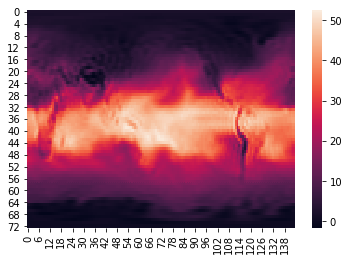

In [9]:
sns.heatmap(prec)

I want to subset the array to the spatial extent of the continental United States.  The longitude bounds should be  -124.848974 to -66.885444. I will need to add 180 degrees to these degrees west to match the convert from degrees east of the nc file. The latitude bounds should be 24.396308 to 49.384358.

In [10]:
# lat and lon bounds
latbounds = [24.4, 49.4]
# lon bounds need to be converted from easterling to westerling to get US
lonbounds = [-124.8 + 360, -66.9 + 360]

# latitude lower and upper bounds
lat_ui = np.argmin(np.abs(lat - latbounds[0]))
lat_li = np.argmin(np.abs(lat - latbounds[1]))

# longitude lower and upper boudns
lon_li = np.argmin(np.abs(lon - lonbounds[0]))
lon_ui = np.argmin(np.abs(lon - lonbounds[1]))
# print index
print(lat_li, lat_ui, lon_li, lon_ui)

(16, 26, 94, 117)


Subset latitude and longitude grid points.

In [11]:
# subset us lon
lon_us = lon[lon_li:lon_ui]-360
# subset us lat
lat_us = lat[lat_li:lat_ui]
# print dimensions
print(np.min(lon_us), np.max(lon_us), np.min(lat_us), np.max(lat_us))

(-125.0, -70.0, 27.5, 50.0)


Print points over US.

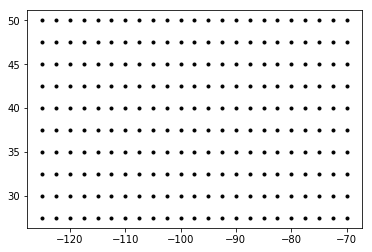

In [12]:
# extract lonlat grid
lons, lats = np.meshgrid(lon_us, lat_us)
# plot
plt.plot(lons, lats, marker='.', color='k', linestyle='none')
plt.show()

In [14]:
# subset temp to us
prec_us = prec_nc.variables['pr_wtr'][1, lat_li:lat_ui, lon_li:lon_ui]
np.shape(prec_us)

(10, 23)

Plot heatmap of US precipitation to make sure subset looks right.

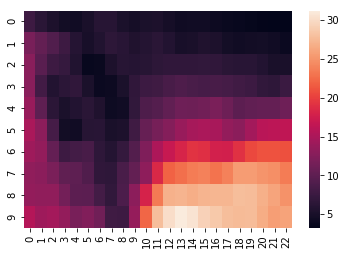

In [15]:
sns.heatmap(prec_us)

### Binary Interpolation of Precipitation to Finer Grid Resolution

Using interpolation to estimate precipitation to a finer grid. Testing out with one array first. Creating a 1x1 degree grid.

In [16]:
# custom grids for every degree
# vectors
grid_lat = np.arange(np.min(lat_us), np.max(lat_us), 1)
grid_lon = np.arange(np.min(lon_us), np.max(lon_us), 1)
# mesh grid array
glons, glats = np.meshgrid(grid_lon, grid_lat)

Plotting new grid to check shape.

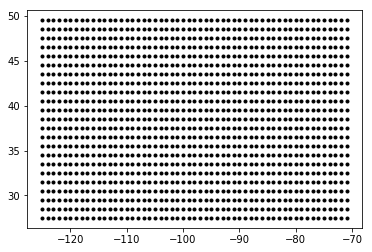

In [17]:
# plot new grid
plt.plot(glons, glats, marker='.', color='k', linestyle='none')
plt.show()

Set up interpoloation spline using RectBivariateSpline, which is faster than interp2D if it's a regular grid (which it is). Lats and Lons need to be sorted and the dimensions need to match shape of value array (ndvi).

In [18]:
# set up interp spline, coordinates need to be 1D arrays, and match the shape of the 3d array.
interp_spline = interpolate.RectBivariateSpline(sorted(lat_us), lon_us, prec_us)

Interpolate the precipitation values from the find grid to coarse grid.

In [19]:
# interpolate to new grid
prec_fine = interp_spline(grid_lat, grid_lon)

Check shape of new coarse grid.

In [20]:
# shape of coarse grid
np.shape(prec_fine)

(23, 55)

Plot the new heatmap of the reshaped grid.

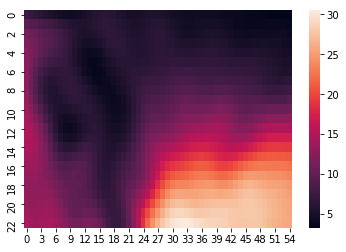

In [21]:
sns.heatmap(prec_fine)

Create custom function to interpolate over each date of array.

In [22]:
# extract full monthly grid
prec_us_full = prec_nc.variables['pr_wtr'][:, lat_li:lat_ui, lon_li:lon_ui]

In [23]:
# check shape
np.shape(prec_us_full)

(844, 10, 23)

In [24]:
# create empty numpy array of 843 days and 23 lon by 55 lat 
prec_fine = np.zeros((844, 23, 55))

# interpolate for each month to new grid
for i in range(844):
    # extract prec element
    prec_mon = prec_us_full[i]
    # create interpolate 
    interp_spline = interpolate.RectBivariateSpline(sorted(lat_us), lon_us, prec_mon)
    # interpolate to new grid
    prec_fine[i] = interp_spline(grid_lat, grid_lon)

In [25]:
# check shape of empty grid
np.shape(prec_fine)

(844, 23, 55)

#### Flatten Regrided Array

In [26]:
# coordinates to a 2 dimension array
us_grid = np.array(np.meshgrid(grid_lon, grid_lat)).reshape(2, -1).T
# check dimensions
np.shape(us_grid)

(1265, 2)

In [27]:
# extract precip array
us_prec = prec_fine.reshape(844,1265).T #.T is for transpose
# check shape
np.shape(us_prec)

(1265, 844)

Creating data frame of us temp and coordinates using pandas. I'm going to create a sequential numeric vector to indicate grid cell id.

In [28]:
# create grid id 1 to 230 and save as type string
grid_id = pd.DataFrame(data = np.arange(1, 1266, 1).T).astype('str')
grid_id.columns = ['grid_id'] 
# head and tail
print(grid_id.head(), grid_id.tail())

(  grid_id
0       1
1       2
2       3
3       4
4       5,      grid_id
1260    1261
1261    1262
1262    1263
1263    1264
1264    1265)


Binding/concatenating grid id variable with lon and lat coordinates.

In [29]:
# create grid dataframe from coordinate array
grid_df = pd.DataFrame(data = us_grid)
# name columns
grid_df.columns = ['lon', 'lat']
# concat dataframes
grid_df = pd.concat([grid_id, grid_df], axis=1)
# view first rows
grid_df.head()
# write grid coords
#grid_df.to_csv('./data/temp_grid.csv')

,grid_id,lon,lat
0,1,-125.0,27.5
1,2,-124.0,27.5
2,3,-123.0,27.5
3,4,-122.0,27.5
4,5,-121.0,27.5


In [30]:
# check tail
grid_df.tail()

,grid_id,lon,lat
1260,1261,-75.0,49.5
1261,1262,-74.0,49.5
1262,1263,-73.0,49.5
1263,1264,-72.0,49.5
1264,1265,-71.0,49.5


Assigning year and month as column header for precipitation values.

In [32]:
from datetime import datetime
# extract date times from nc file; define units
date = nc.num2date(time, 'hours since 1800-01-01 00:00:0.0')
# ts
ts = pd.Series(date, index = date)
# view first couple observations
print(ts.head(), ts.tail())

(1948-01-01   1948-01-01
1948-02-01   1948-02-01
1948-03-01   1948-03-01
1948-04-01   1948-04-01
1948-05-01   1948-05-01
dtype: datetime64[ns], 2017-12-01   2017-12-01
2018-01-01   2018-01-01
2018-02-01   2018-02-01
2018-03-01   2018-03-01
2018-04-01   2018-04-01
dtype: datetime64[ns])


Convert precipitation array to dataframe.

In [33]:
# array to dataframe
prec_df = pd.DataFrame(data = us_prec)
# add name
prec_df.columns = ts.dt.date

Bind precipitation values to coordinate and grid id and then melt/gather columns to row.

In [34]:
# concat grid id and temp
prec_wide_df = pd.concat([grid_df, prec_df], axis = 1)
prec_wide_df.head()

,grid_id,lon,lat,1948-01-01,1948-02-01,1948-03-01,1948-04-01,1948-05-01,1948-06-01,1948-07-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
0,1,-125.0,27.5,10.483224,7.719310,8.116448,8.284335,13.522258,18.429333,18.633549,...,16.408871,17.406450,18.480000,12.555647,11.666669,9.559678,11.826612,8.472322,8.513710,9.965834
1,2,-124.0,27.5,9.570420,7.099259,7.293138,7.908143,13.197092,17.607729,17.508149,...,15.167670,16.267673,17.387723,11.844602,11.071812,8.949821,11.162736,7.764403,8.078946,9.311263
2,3,-123.0,27.5,8.778687,6.568684,6.624942,7.623624,12.922004,16.949778,16.553248,...,14.086579,15.360612,16.400645,11.228768,10.511423,8.417975,10.541044,7.175934,7.704925,8.761582
3,4,-122.0,27.5,8.084807,6.110858,6.079917,7.400668,12.676305,16.430395,15.748014,...,13.166814,14.650359,15.495123,10.679424,9.972212,7.920734,9.943308,6.662139,7.356915,8.281352
4,5,-121.0,27.5,7.465563,5.709055,5.626121,7.209163,12.439309,16.024496,15.071618,...,12.409592,14.102006,14.647512,10.167849,9.440890,7.414695,9.351295,6.178241,7.000184,7.835137


In [35]:
# wide to long
prec_long_df = pd.melt(prec_wide_df, id_vars = ['grid_id', 'lon', 'lat'],
                      var_name = "date", value_name = "prec_kgm2")
# view head of final row-wise dataset
prec_long_df.head()

,grid_id,lon,lat,date,prec_kgm2
0,1,-125.0,27.5,1948-01-01,10.483224
1,2,-124.0,27.5,1948-01-01,9.570420
2,3,-123.0,27.5,1948-01-01,8.778687
3,4,-122.0,27.5,1948-01-01,8.084807
4,5,-121.0,27.5,1948-01-01,7.465563


In [36]:
# describe dataframe
prec_long_df.describe()

,lon,lat,prec_kgm2
count,1.067660e+06,1.067660e+06,1.067660e+06
mean,-9.800000e+01,3.850000e+01,1.699604e+01
std,1.587452e+01,6.633253e+00,9.454317e+00
min,-1.250000e+02,2.750000e+01,1.672208e+00
25%,-1.120000e+02,3.250000e+01,9.382856e+00
50%,-9.800000e+01,3.850000e+01,1.497848e+01
75%,-8.400000e+01,4.450000e+01,2.262324e+01
max,-7.100000e+01,4.950000e+01,5.267440e+01


In [37]:
# print min and max date
print(prec_long_df['date'].min(), prec_long_df['date'].max())

(datetime.date(1948, 1, 1), datetime.date(2018, 4, 1))


Saving long monthly precipitation for regrided US grid to csv.

In [38]:
# commented out to not write again
#prec_long_df.to_csv('../data/1948-2018_mon_pr_wtr_us.csv')

#### Summary Plot

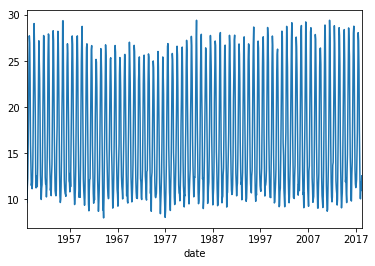

In [40]:
# mean US temperature grid time series
mean_pr = prec_long_df.groupby(['date'])['prec_kgm2'].mean()
# mean plot
mean_pr.plot(x='date', y='prec_kgm2')